In [1]:
import pandas as pd
import re
import os
import importlib
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter('always')

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Loading & Cleaning

In [2]:
csv_path = "results/controlled_results.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ All rows have consistent 'total_generated_tokens' = 16384
----------------------------------------------------------------------------------------------------
⚠️ FLOPs values are NOT constant: [1.6949971e+13 0.0000000e+00]
Original distribution:
flops
0.000000e+00    185
1.694997e+13    554
Name: count, dtype: int64
- Dominant FLOPs value: 16949970993152.0
- Affected rows count: 185
- Affected row indices: [329, 330, 331, 342, 343, 345, 346, 347, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 459, 460, 461, 462, 46

/Users/henrybaker/repositories/thesis_analysis/scripts/a_data_loading_cleaning.py:574: UserWarning: ⚠️ FLOPs values are NOT constant: [1.6949971e+13 0.0000000e+00]
  verify_flops(df)


In [3]:
df['flops'] = 16949970993152.0
df['flops_per_token'] = df['flops'] / df['total_generated_tokens']

# Exploratory Data Analysis (EDA)

📊 Plotting histogram...


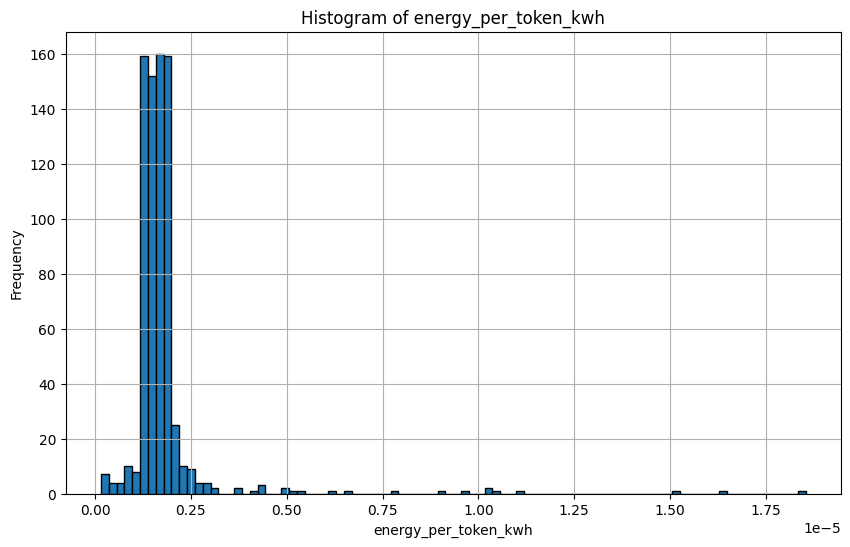

📦 Plotting boxplot...


/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  plt.boxplot(data[column].dropna(), vert=False)


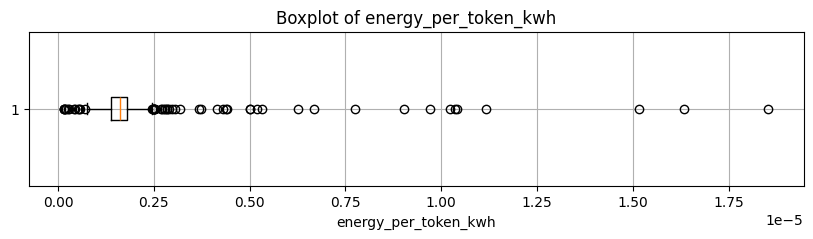

🔬 Scatter: Energy vs FLOPs...


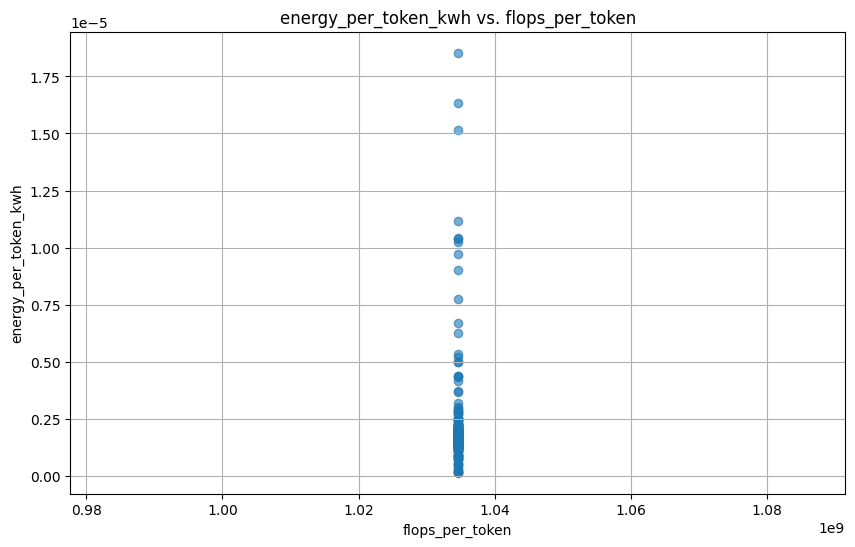

📈 Scatter: Divergence vs Batch Size...


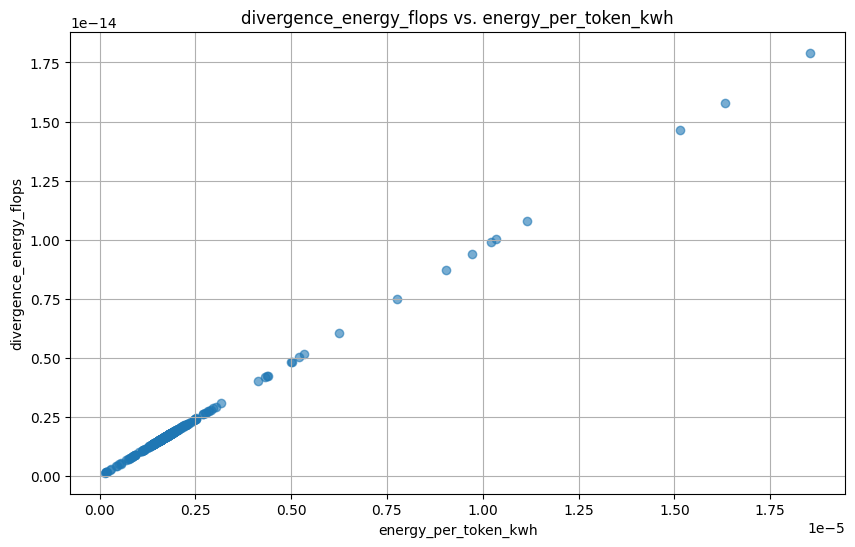

🔗 Correlation matrix...


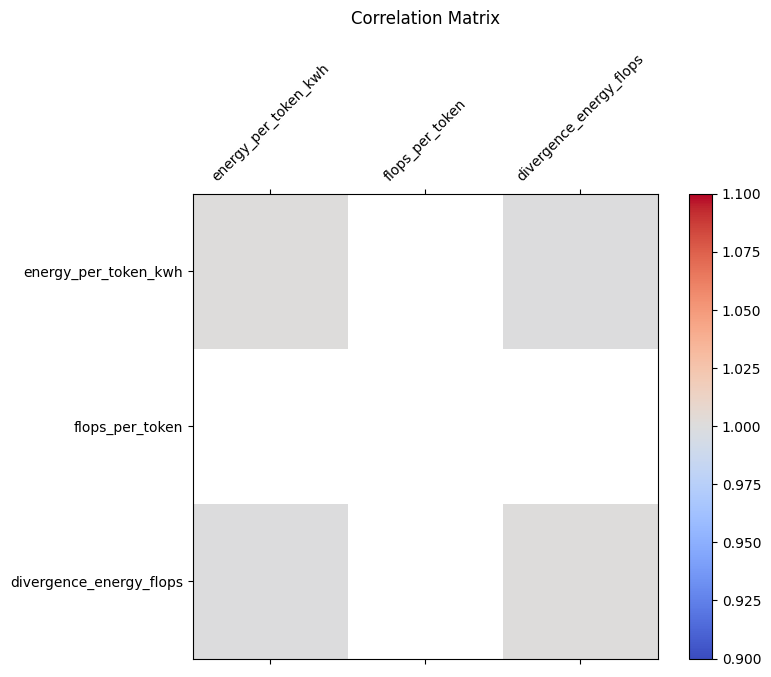

In [4]:
from scripts.b_exploratory_data_analysis import (
    plot_histogram,
    plot_boxplot,
    plot_scatter,
    plot_divergence,
    plot_correlation_matrix,
    plot_all_diagnostics
)

plot_all_diagnostics(df)

To do: 
- [ ] crop outliers temporarily -> look at closer grouped in more detail
- [ ] examine the divergence plot more

# Controlled Experiment Visualisation

NB: THE STD ERROR BAR EXTENDS BEYOND THE RAW OBSERVATIONS????

- [ ] FLOPs to be visually diff
- [ ] decoder temp yaxis not normalising
- [ ] if decoder temp remains a mess, print stratified by cycle

In [ ]:
import numpy as np

import importlib
import scripts.c_controlled_exp_visualisations as viz
importlib.reload(viz)

from scripts.c_controlled_exp_visualisations import (
    plot_num_processes,
    plot_batching,
    plot_precision,
    plot_decoder_temperature,
    plot_decoder_topk_top_p,
    plot_latency_by_burst_interval,
    plot_latency_by_burst_size
    plot_all_vizs,
)

configs = ['num_processes', 'batching','precis', 'decoding', 'latency']
dfs = {config: df[df['config_name'].str.startswith(config)] for config in configs}

plot_latency_by_burst_interval(dfs)
plot_latency_by_burst_interval(dfs, normalise_axes=['ax1'])
plot_latency_by_burst_interval(dfs, normalise_axes=['ax1'], plot_band=False, plot_raw=False)

plot_latency_by_burst_size(dfs)
plot_latency_by_burst_size(dfs, normalise_axes=['ax1'])
plot_latency_by_burst_size(dfs, normalise_axes=['ax1'], plot_band=False, plot_raw=False)


/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'plot_latency_by_burst_interval' is not defined

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_1106/1405489729.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(sizes)+1)


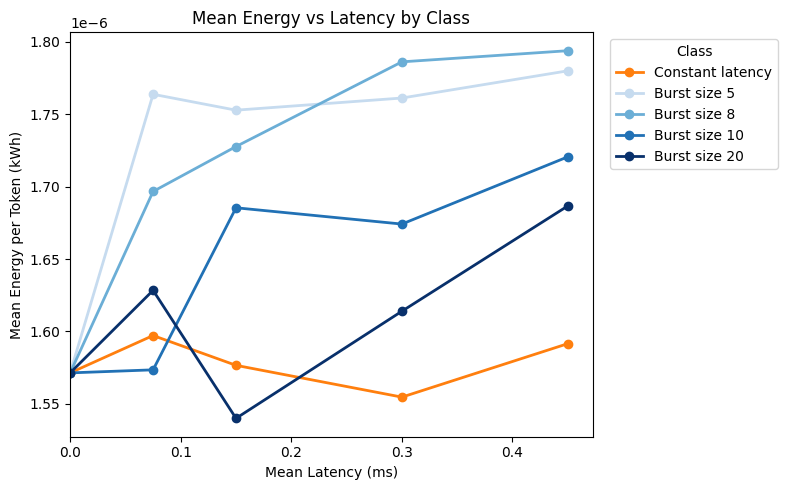

In [85]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

def add_latency_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['latency_numeric'] = df.apply(
        lambda r: 0.0
            if not r['latency_simulation_simulate']
            else (r['latency_simulation_delay_min'] +
                  r['latency_simulation_delay_max'])/2,
        axis=1
    )
    return df

def classify_by_burst_size_and_constant(df: pd.DataFrame):
    """
    Returns (df2, sizes), where df2 has new boolean columns:
      - class_const
      - class_burst_<size>  for each unique burst size
    and every column is OR’ed with the zero‑latency origin.
    """
    df = add_latency_numeric(df.copy())
    origin = df['latency_numeric'] == 0.0

    # 1) constant = simulate on & not burst, OR origin
    df['class_const'] = (
        (df['latency_simulation_simulate'] &
         ~df['latency_simulation_simulate_burst'])
        | origin
    )

    # 2) one column per burst size
    burst_rows = df['latency_simulation_simulate_burst']
    sizes = sorted(df.loc[burst_rows, 'latency_simulation_burst_size'].unique())
    for sz in sizes:
        col = f'class_burst_{sz}'
        df[col] = (
            (df['latency_simulation_simulate_burst'] &
             (df['latency_simulation_burst_size'] == sz))
            | origin
        )

    return df, sizes

def plot_mean_energy_by_class(df: pd.DataFrame, sizes: list):
    """
    Plots mean energy_per_token_kwh vs latency_numeric for:
      - Constant latency (orange)
      - Each burst_size (blue ramp)
    """
    # Color map
    cmap = cm.get_cmap('Blues', len(sizes)+1)
    colors = {'class_const': 'tab:orange'}
    for i, sz in enumerate(sizes, start=1):
        colors[f'class_burst_{sz}'] = cmap(i)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel("Mean Latency (ms)")
    ax.set_ylabel("Mean Energy per Token (kWh)")
    ax.set_title("Mean Energy vs Latency by Class")

    # Plot constant
    const_series = (
        df[df['class_const']]
          .groupby('latency_numeric')['energy_per_token_kwh']
          .mean()
    )
    ax.plot(const_series.index,
            const_series.values,
            label='Constant latency',
            color=colors['class_const'],
            marker='o', linewidth=2)

    # Plot each burst‐size
    for sz in sizes:
        col = f'class_burst_{sz}'
        series = (
            df[df[col]]
              .groupby('latency_numeric')['energy_per_token_kwh']
              .mean()
        )
        ax.plot(series.index,
                series.values,
                label=f'Burst size {sz}',
                color=colors[col],
                marker='o', linewidth=2)

    ax.set_xlim(left=0)
    ax.legend(title='Class', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Usage:
df0 = dfs['latency']                    # your raw DataFrame
df1, burst_sizes = classify_by_burst_size_and_constant(df0)
plot_mean_energy_by_class(df1, burst_sizes)


/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_1106/3079890092.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(intervals) + 1)


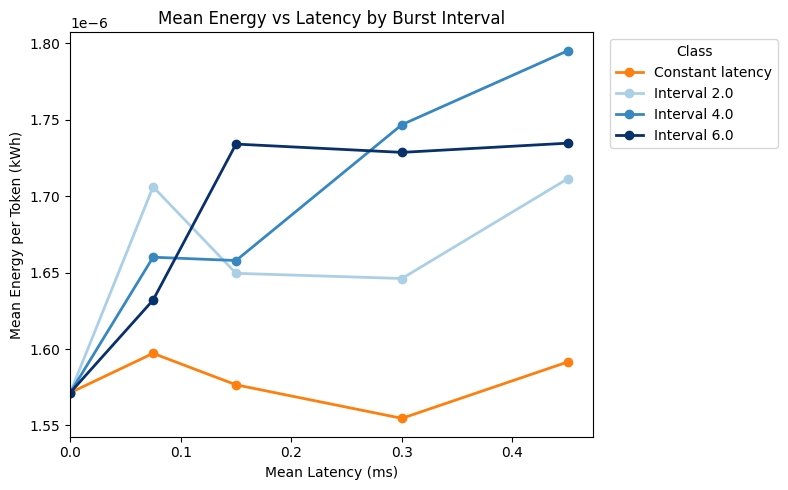

In [86]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

def add_latency_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['latency_numeric'] = df.apply(
        lambda r: 0.0
            if not r['latency_simulation_simulate']
            else (r['latency_simulation_delay_min'] +
                  r['latency_simulation_delay_max']) / 2,
        axis=1
    )
    return df

def classify_by_burst_interval_and_constant(df: pd.DataFrame):
    """
    Returns (df2, intervals), where df2 has new boolean columns:
      - class_const
      - class_interval_<interval> for each unique burst interval
    and every column is OR’ed with the zero‑latency origin.
    """
    df = add_latency_numeric(df.copy())
    origin = df['latency_numeric'] == 0.0

    # Constant-latency: simulate on & not burst, OR origin
    df['class_const'] = (
        (df['latency_simulation_simulate'] &
         ~df['latency_simulation_simulate_burst'])
        | origin
    )

    # Discover unique burst intervals
    burst_rows = df['latency_simulation_simulate_burst']
    intervals = sorted(df.loc[burst_rows, 'latency_simulation_burst_interval'].unique())

    # Create one boolean column per interval
    interval_cols = []
    for interval in intervals:
        col = f'class_interval_{interval}'
        df[col] = (
            (df['latency_simulation_simulate_burst'] &
             (df['latency_simulation_burst_interval'] == interval))
            | origin
        )
        interval_cols.append(col)

    return df, intervals

def plot_mean_energy_by_interval(df: pd.DataFrame, intervals: list):
    """
    Plots mean energy_per_token_kwh vs latency_numeric for:
      - Constant latency (orange)
      - Each burst interval (blue ramp)
    """
    cmap = cm.get_cmap('Blues', len(intervals) + 1)
    colors = {'class_const': 'tab:orange'}
    for i, interval in enumerate(intervals, start=1):
        colors[f'class_interval_{interval}'] = cmap(i)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel("Mean Latency (ms)")
    ax.set_ylabel("Mean Energy per Token (kWh)")
    ax.set_title("Mean Energy vs Latency by Burst Interval")

    # Plot constant
    const_series = (
        df[df['class_const']]
          .groupby('latency_numeric')['energy_per_token_kwh']
          .mean()
    )
    ax.plot(const_series.index,
            const_series.values,
            label='Constant latency',
            color=colors['class_const'],
            marker='o', linewidth=2)

    # Plot each burst interval
    for interval in intervals:
        col = f'class_interval_{interval}'
        series = (
            df[df[col]]
              .groupby('latency_numeric')['energy_per_token_kwh']
              .mean()
        )
        ax.plot(series.index,
                series.values,
                label=f'Interval {interval}',
                color=colors[col],
                marker='o', linewidth=2)

    ax.set_xlim(left=0)
    ax.legend(title='Class', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Usage example:
df0 = dfs['latency']
df1, intervals = classify_by_burst_interval_and_constant(df0)
plot_mean_energy_by_interval(df1, intervals)


In [8]:
from matplotlib import cm

def classify_latency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with these columns:
      - latency_simulation_simulate (bool)
      - latency_simulation_simulate_burst (bool)
      - latency_simulation_delay_min (float)
      - latency_simulation_delay_max (float)
      - flops_per_token
      - energy_per_token_kwh
    Returns a new DataFrame with boolean columns:
      - latency_constant
      - latency_bursty
      - one column per unique burst-range tuple (min,max)
    plus flops_per_token and energy_per_token_kwh.
    """
    df = df.copy()
    
    # Base flags
    bursty = df['latency_simulation_simulate_burst'].fillna(False)
    constant = ~bursty
    no_sim = ~df['latency_simulation_simulate'].fillna(False)

    # Combined columns
    df['latency_bursty'] = bursty | no_sim
    df['latency_constant'] = constant | no_sim

    # Identify unique burst ranges
    burst_ranges = (
        df[bursty][['latency_simulation_delay_min', 'latency_simulation_delay_max']]
        .drop_duplicates()
        .apply(tuple, axis=1)
        .tolist()
    )

    # Create one boolean column per range
    for dmin, dmax in burst_ranges:
        col_name = f"burst_{dmin}_{dmax}"
        df[col_name] = (
            df['latency_simulation_simulate_burst'] &
            (df['latency_simulation_delay_min'] == dmin) &
            (df['latency_simulation_delay_max'] == dmax)
        )

    keep_cols = [
        'flops_per_token',
        'energy_per_token_kwh',
        'latency_simulation_simulate',
        'latency_simulation_delay_min',
        'latency_simulation_delay_max',
    ]
    new_latency_cols = [
        'latency_numeric',
        'latency_constant', 
        'latency_bursty'
    ]
    burst_cols = [f"burst_{dmin}_{dmax}" for dmin, dmax in burst_ranges]
    
    result = df.loc[:, keep_cols + new_latency_cols + burst_cols]
    
    return result

def add_latency_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'latency_numeric' column to a DataFrame:
    - 0.0 if latency_simulation_simulate is False
    - else mean of latency_simulation_delay_min and _max
    """
    df = df.copy()
    df['latency_numeric'] = df.apply(
        lambda r: 0.0
            if not r.get('latency_simulation_simulate', False)
            else (float(r['latency_simulation_delay_min']) +
                float(r['latency_simulation_delay_max'])) / 2,
        axis=1
    )
    return df


df0 = dfs['latency']
df1 = add_latency_numeric(df0)  
df2 = classify_latency(df1)      

print("Burst columns and their row‐counts:")
for c in df2.columns:
    if c.startswith("burst_"):
        print(f"  {c:15s} → {df2[c].sum()} rows")



Burst columns and their row‐counts:
  burst_0.1_0.2   → 59 rows
  burst_0.05_0.1  → 57 rows
  burst_0.4_0.5   → 57 rows
  burst_0.2_0.4   → 58 rows


TO DO: WORK OUT % OF TOTAL ENERGY CONSUMPTION / VARIANCE THAT CAN BE EXPLAINED BY TOTAL CONFIGS CHANGES VS BASELINE THAT IS MODEL DETERMINED

# Modeling


📊 Running OLS regression for energy_per_token_kwh...

                             OLS Regression Results                             
Dep. Variable:     energy_per_token_kwh   R-squared:                       0.333
Model:                              OLS   Adj. R-squared:                  0.244
Method:                   Least Squares   F-statistic:                     3.748
Date:                  Sat, 19 Apr 2025   Prob (F-statistic):             0.0478
Time:                          20:15:24   Log-Likelihood:                 225.44
No. Observations:                    18   AIC:                            -444.9
Df Residuals:                        15   BIC:                            -442.2
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


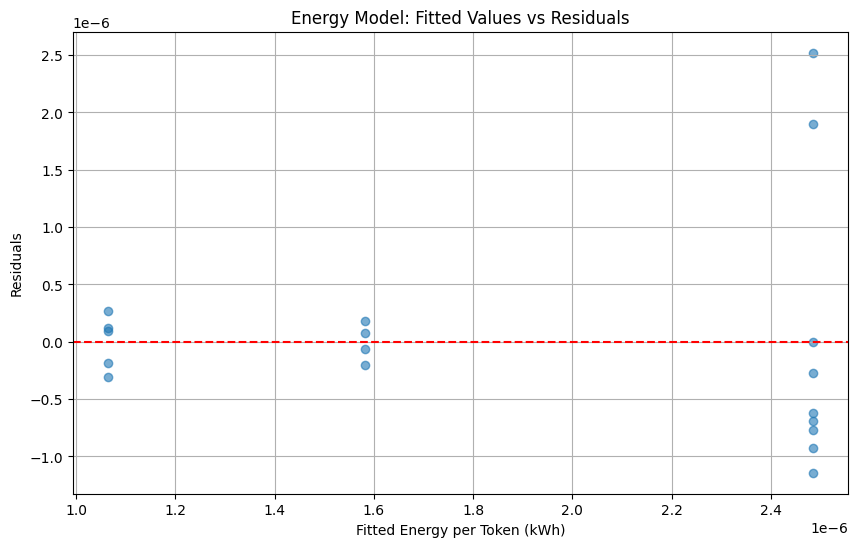


📊 Running OLS regression for energy_per_token_kwh...

                             OLS Regression Results                             
Dep. Variable:     energy_per_token_kwh   R-squared:                       0.333
Model:                              OLS   Adj. R-squared:                  0.244
Method:                   Least Squares   F-statistic:                     3.748
Date:                  Sat, 19 Apr 2025   Prob (F-statistic):             0.0478
Time:                          20:15:24   Log-Likelihood:                 225.44
No. Observations:                    18   AIC:                            -444.9
Df Residuals:                        15   BIC:                            -442.2
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


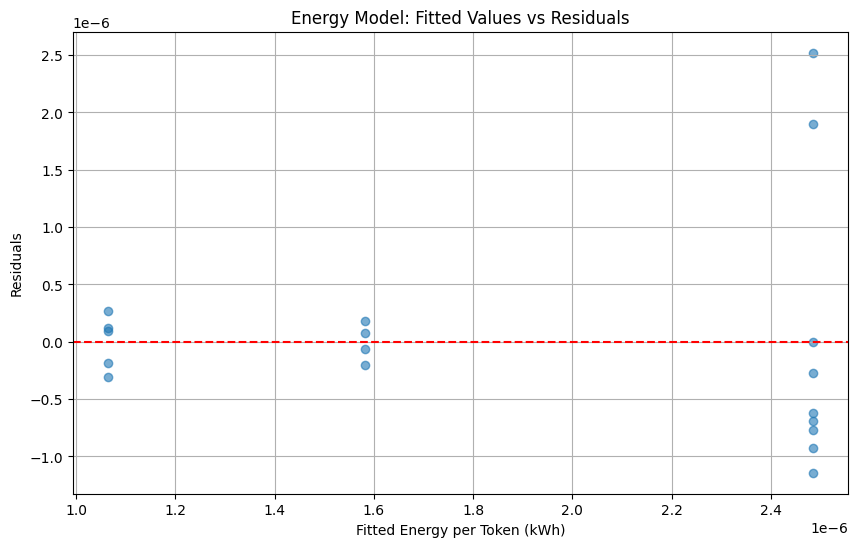

In [10]:
from scripts.d_base_regression import run_full_regression_analysis, preprocess_data

df = preprocess_data(df)

# With default predictors
run_full_regression_analysis(df)

# With custom predictors
custom_predictors = ["batch_size_numeric", "C(fp_precision)", "C(quantization)"]
run_full_regression_analysis(df, predictors=custom_predictors)


In [11]:
%run scripts/d_mixed_effects_model.py

/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


Exception: File `'scripts/d_mixed_effects_model.py'` not found.

In [ ]:
df['energy_per_token_kwh'].max() -  df['energy_per_token_kwh'].min() 

np.float64(1.6171286190094204e-05)

Modelling to do
- [ ] set up hoerarchical model -> identify groupings:
   - [ ] use model (even though currently only one model)
   - [ ] use config_name and date_time
   - [ ] use decoder configs
   - [ ] latency configs 